<h2>Time Series Task</h2> 

<h3>Data Processing</h3> 

In [1]:
###Problem 1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

#Load datasets generated
baseline_df = pd.read_csv('/Users/hteshome/Desktop/Training/Pytools_Class/08-time-stats-and-ml-haile-teshome/patient_baseline.csv', sep='\t')
longitudinal_df = pd.read_csv('/Users/hteshome/Desktop/Training/Pytools_Class/08-time-stats-and-ml-haile-teshome/patient_longitudinal.csv', sep='\t')
treatment_df = pd.read_csv('/Users/hteshome/Desktop/Training/Pytools_Class/08-time-stats-and-ml-haile-teshome/patient_treatment.csv', sep='\t')

#Convert visit_date to datetime format
longitudinal_df['visit_date'] = pd.to_datetime(longitudinal_df['visit_date'], format='%Y-%m-%d')
longitudinal_df.set_index('visit_date', inplace=True)

#Manage duplicates by averaging values for duplicate dates
if longitudinal_df.index.duplicated().sum() > 0:
    longitudinal_df = longitudinal_df.groupby(['patient_id', longitudinal_df.index]).mean()

#Fill missing values using interpolation
longitudinal_df['bp_systolic'] = longitudinal_df['bp_systolic'].interpolate()
longitudinal_df['heart_rate'] = longitudinal_df['heart_rate'].interpolate()

#Reset index to use only visit_date for resampling
#This removes patient_id from the index temporarily
longitudinal_df_reset = longitudinal_df.reset_index().set_index('visit_date')


###Problem 2
#Resample the bp_systolic data to monthly frequency
monthly_bp = longitudinal_df_reset['bp_systolic'].resample('M').mean()

#Calculate a 3-month moving average 
moving_avg_bp = monthly_bp.rolling(window=3, min_periods=1).mean()




<h3>Time Series Plot</h3> 

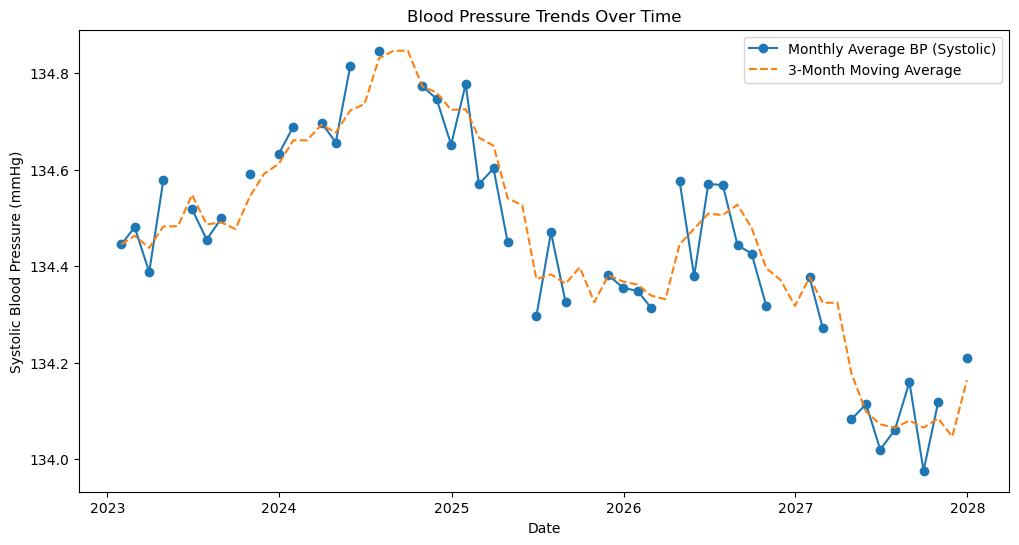

In [2]:
# Plot the original and smoothed blood pressure trends vs time
plt.figure(figsize=(12, 6))
plt.plot(monthly_bp, label="Monthly Average BP (Systolic)", marker='o')
plt.plot(moving_avg_bp, label="3-Month Moving Average", linestyle='--')
plt.title("Blood Pressure Trends Over Time")
plt.xlabel("Date")
plt.ylabel("Systolic Blood Pressure (mmHg)")
plt.legend()
plt.show()

<h2>Statistical Modeling Tasks</h2> 

<h3>Model Fitting</h3> 

In [28]:
###Problem 1 
import statsmodels.api as sm
import matplotlib.pyplot as plt

#Define target and predictor variables
y = baseline_df['bp_systolic']
X = baseline_df[['age', 'bmi', 'smoking', 'diabetes']]

#Add intercept to model
X = sm.add_constant(X)

#Fit the OLS model 
ols_model = sm.OLS(y, X).fit(cov_type='HC3')

#Display the summary of the model
print(ols_model.summary())



                            OLS Regression Results                            
Dep. Variable:            bp_systolic   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     149.1
Date:                Wed, 06 Nov 2024   Prob (F-statistic):          6.36e-100
Time:                        00:07:35   Log-Likelihood:                -3700.7
No. Observations:                1000   AIC:                             7411.
Df Residuals:                     995   BIC:                             7436.
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        108.4929      1.979     54.812      0.0

The r-squared value of 0.376 is showing that that approximately 37.6% of the variance in systolic blood pressure can be explained by the model. While this a moderate fit, there is likely also many other factors in play more parameters will have a significant effect on blood pressure.
The F-statistic is 149.1 with a very small p-value, indicating that the overall model is statistically significant.

<h3>Modeling Performance Evaluation</h3> 

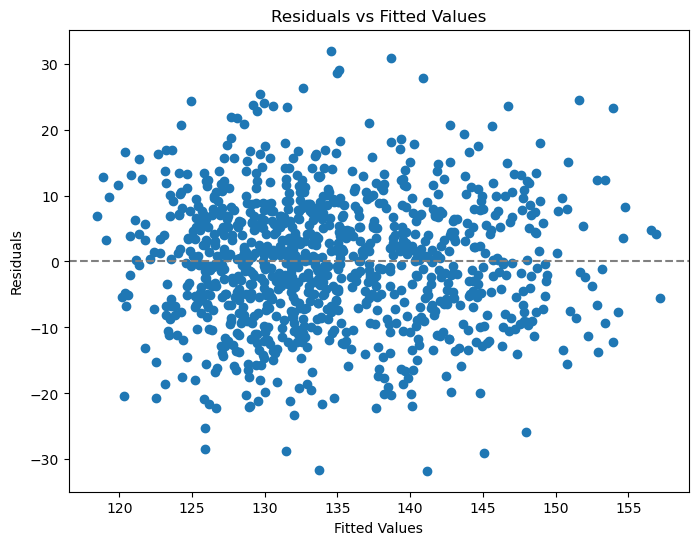

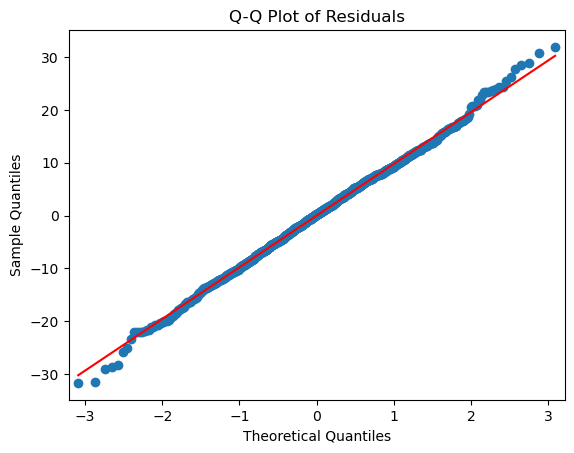

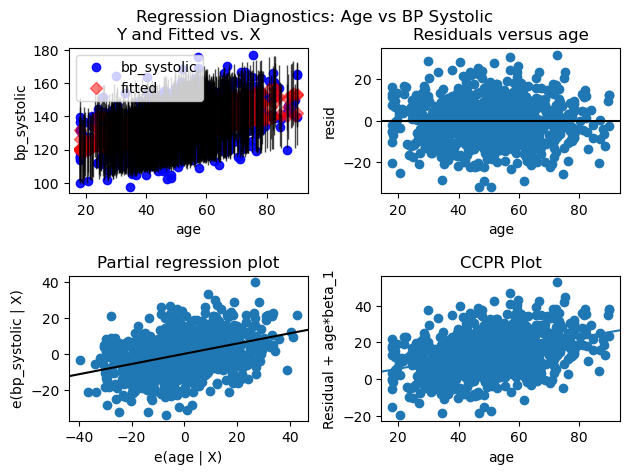

In [29]:
#Plot Residuals vs Fitted Values, QQ Plot of Residuals, and Regression Diagnostic Plot for age 
plt.figure(figsize=(8, 6))
plt.scatter(ols_model.fittedvalues, ols_model.resid)
plt.axhline(y=0, color='gray', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()
sm.qqplot(ols_model.resid, line='s')
plt.title("Q-Q Plot of Residuals")
plt.show()
fig = sm.graphics.plot_regress_exog(ols_model, 'age')
fig.suptitle("Regression Diagnostics: Age vs BP Systolic")
plt.show()

The diagnostic plots indicate that model assumptions are largely met. There are no major issues with non-linearity or heteroscedasticity, though there is some minor spread in residuals at higher fitted values. The normality of residuals appears to hold, supporting the use of this OLS model for inference. Diagnostic plots indicate that the model assumptions are mostly true which suggests that the model is a valid inference although performance needs improvement.

<h3>Modeling Fitting</h3> 

In [30]:
##Problem 2

#Define target and predictor variables
y_treatment = treatment_df['outcome']
X_treatment = treatment_df[['age', 'bmi', 'smoking', 'diabetes', 'adherence']]

#Add constant term to predictors
X_treatment = sm.add_constant(X_treatment)

#Fit GLM with binomial family
glm_model_treatment = sm.GLM(y_treatment, X_treatment, family=sm.families.Binomial()).fit()



<h3>Modeling Performance Evaluation</h3> 

In [31]:
#Display results
print(glm_model_treatment.summary())
odds_ratios = np.exp(glm_model_treatment.params)
conf_intervals = np.exp(glm_model_treatment.conf_int())
print("Odds Ratios:\n", odds_ratios)
print("\nConfidence Intervals:\n", conf_intervals)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      994
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -656.42
Date:                Wed, 06 Nov 2024   Deviance:                       1312.8
Time:                        00:11:27   Pearson chi2:                 1.00e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.01896
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2681      0.691     -1.836      0.0

The GLM analysis shows that BMI and diabetes are significant predictors of the outcome with BMI slightly increasing the odds of a positive outcome and diabetes significantly decreasing it. Smoking has a borderline negative impact, while age and adherence do not significantly affect the outcome. However, the model explains only about 1.9% of the variance based on the R-squared = 0.01896, indicating a poor fit. This suggests that additional predictors may be needed to better capture the factors influencing the outcome or different methods need to be used.

<h2>Machine Learning Tasks</h2> 

In [32]:
###Problem 1
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, roc_auc_score, 
    confusion_matrix, classification_report, RocCurveDisplay
)

#Define features and target variable
X = treatment_df[['age', 'bmi', 'smoking', 'diabetes', 'adherence']]
y = treatment_df['outcome']

#Create a pipeline for standardizing features and fitting logistic regression
pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        penalty='l2',             
        solver='lbfgs',          
        max_iter=1000,           
        class_weight='balanced'  
    )
)


In [37]:
###Problem 2
#Split the data into training and test sets 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

#Define StratifiedKFold for cross-validation to maintain class distribution
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#Perform cross-validation
scores = cross_validate(
    pipeline,
    X_train, y_train,
    cv=cv,
    scoring=['accuracy', 'precision', 'recall', 'roc_auc']
)

print("Cross-Validation Results:")
print(f"Accuracy: {np.mean(scores['test_accuracy']):.2f}")
print(f"Precision: {np.mean(scores['test_precision']):.2f}")
print(f"Recall: {np.mean(scores['test_recall']):.2f}")
print(f"ROC AUC: {np.mean(scores['test_roc_auc']):.2f}")


Cross-Validation Results:
Accuracy: 0.54
Precision: 0.43
Recall: 0.59
ROC AUC: 0.55


In [36]:
#Fit the pipeline on the entire training set
pipeline.fit(X_train, y_train)

#Predict on the test set
y_pred = pipeline.predict(X_test)

#Generate classification metrics 
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])

print("\nTest Set Performance:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")
print(classification_report(y_test, y_pred))



Test Set Performance:
Accuracy: 0.53
Precision: 0.41
Recall: 0.52
ROC AUC: 0.57
              precision    recall  f1-score   support

           0       0.64      0.54      0.58       185
           1       0.41      0.52      0.46       115

    accuracy                           0.53       300
   macro avg       0.53      0.53      0.52       300
weighted avg       0.55      0.53      0.54       300



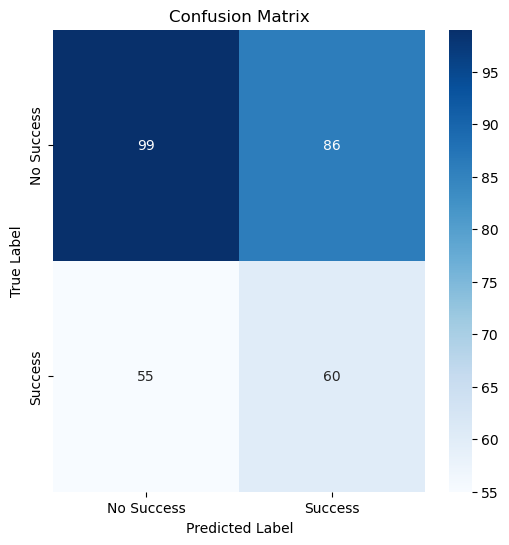

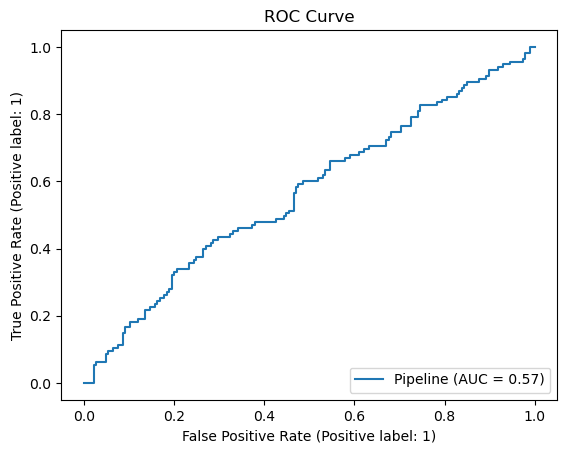

In [35]:
#Generate and display the confusion matrix and ROC curve
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Success", "Success"], yticklabels=["No Success", "Success"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
RocCurveDisplay.from_estimator(pipeline, X_test, y_test)
plt.title("ROC Curve")
plt.show()
